In [1]:
import pickle
with open("curated_xgboost_results.pkl", "rb") as f:
    search, best_xgb, X_stop_xgb, y_stop_xgb, X_train_xgb, y_train_xgb = pickle.load(f)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
booster = best_xgb.get_booster()
df_trees = booster.trees_to_dataframe()
df_trees.head()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,f36,2.565718,0-1,0-2,0-2,294680832.0,2612620.0,NaN
1,0,1,0-1,f36,1.697449,0-3,0-4,0-4,65407416.0,2418525.0,NaN
2,0,2,0-2,f36,3.348851,0-5,0-6,0-6,61886368.0,194095.0,NaN
3,0,3,0-3,f36,1.184790,0-7,0-8,0-8,9293464.0,1745062.0,NaN
4,0,4,0-4,f35,1.000000,0-9,0-10,0-10,25430290.0,673463.0,NaN


In [7]:
import pandas as pd
from collections import deque

def compute_depths_by_id(df):
    dfs = []

    for tree_id, g in df.groupby("Tree"):
        g = g.copy()

        # Build parent -> children mapping using ID strings
        children = {}
        for _, row in g.iterrows():
            parent_id = row["ID"]
            ch = {row["Yes"], row["No"], row["Missing"]}
            ch = {c for c in ch if isinstance(c, str)}  # keep only valid child IDs
            children[parent_id] = ch

        # root ID convention from xgboost: f"{tree_id}-0"
        root_id = f"{tree_id}-0"

        # BFS over IDs to assign depths
        q = deque([(root_id, 0)])
        id_depth = {}

        while q:
            nid, d = q.popleft()
            if nid in id_depth:
                continue
            id_depth[nid] = d
            for ch in children.get(nid, []):
                if ch not in id_depth:
                    q.append((ch, d + 1))

        # attach depth via ID
        g["Depth"] = g["ID"].map(id_depth).fillna(0).astype(int)
        dfs.append(g)

    return pd.concat(dfs, ignore_index=True)

df_trees = compute_depths_by_id(df_trees)
depth_by_tree = df_trees.groupby("Tree")["Depth"].max()
print(depth_by_tree.describe())

count    300.0
mean       8.0
std        0.0
min        8.0
25%        8.0
50%        8.0
75%        8.0
max        8.0
Name: Depth, dtype: float64


In [6]:
df_leaves = df_trees[df_trees["Feature"] == "Leaf"]

print(df_leaves["Cover"].describe())

count    5.787700e+04
mean     1.354227e+04
std      8.297547e+04
min      1.000000e+01
25%      3.600000e+01
50%      3.520000e+02
75%      3.502000e+03
max      2.363817e+06
Name: Cover, dtype: float64


In [8]:
with open("X_cur_train.pkl", "rb") as f:
    X_cur_train = pickle.load(f)

with open("X_cur_val.pkl", "rb") as f:
    X_cur_val = pickle.load(f)

with open("df_train.pkl", "rb") as f:
    df_train = pickle.load(f)
y_train = df_train.base_passenger_fare.values
del df_train

with open("df_val.pkl", "rb") as f:
    df_val = pickle.load(f)
y_val = df_val.base_passenger_fare.values
del df_val

In [ ]:

from sklearn.metrics import root_mean_squared_error
# Evaluate best XGB on validation set explicitly:
y_pred_train = best_xgb.predict(X_cur_train)
xgb_train_rmse = root_mean_squared_error(y_train, y_pred_train)

y_pred_val = best_xgb.predict(X_cur_val)
xgb_val_rmse = root_mean_squared_error(y_val, y_pred_val)

In [12]:

from sklearn.metrics import root_mean_squared_error
xgb_train_rmse = root_mean_squared_error(y_train, y_pred_train)

y_pred_val = best_xgb.predict(X_cur_val)
xgb_val_rmse = root_mean_squared_error(y_val, y_pred_val)

In [16]:
df_y_pred_train = pd.DataFrame({
    "y_train": y_train,
    "y_pred_train": y_pred_train
})

df_y_pred_train=df_y_pred_train.sort_values("y_train").reset_index(drop=True)

df_y_pred_val = pd.DataFrame({
    "y_val": y_val,
    "y_pred_val": y_pred_val
})

df_y_pred_val=df_y_pred_val.sort_values("y_val").reset_index(drop=True)

C:\Users\yvnyl\AppData\Local\uv\cache\archive-v0\5dEDSFYa2ARZk-CGsjuDB\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


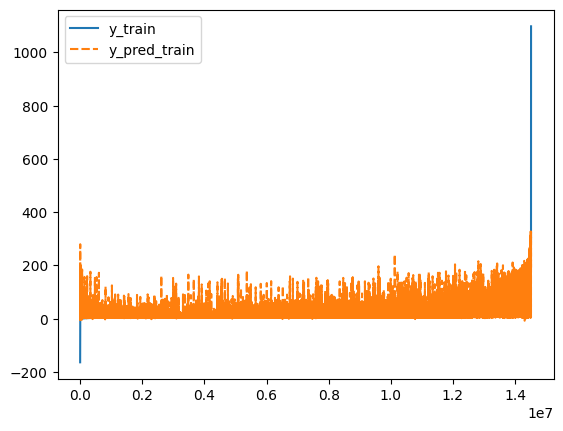

In [17]:
import matplotlib.pyplot as plt

sns.lineplot(data=df_y_pred_train[["y_train","y_pred_train"]])
plt.show()

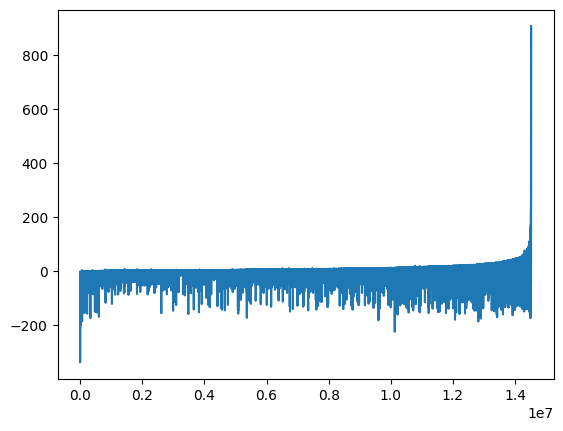

In [19]:
sns.lineplot(data=df_y_pred_train.y_train-df_y_pred_train.y_pred_train)
plt.show()

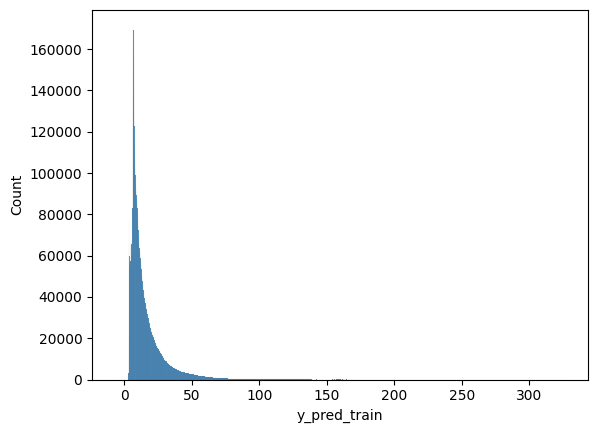

In [20]:
sns.histplot(df_y_pred_train.y_pred_train)
plt.show()

In [27]:
df_y_pred_train.columns.tolist()

['y_train', 'y_pred_train']

In [30]:
set(df_y_pred_train.columns) == set(['y_pred_train', 'y_train', ])

True

In [31]:
df = pd.read_parquet('data/fhvhv_tripdata_2019-02.parquet')
df = df.iloc[0:10,:].copy()

In [34]:
set(df.columns) == {'DOLocationID',
                     'PULocationID',
                     'access_a_ride_flag',
                     'airport_fee',
                     'base_passenger_fare',
                     'bcf',
                     'congestion_surcharge',
                     'dispatching_base_num',
                     'driver_pay',
                     'dropoff_datetime',
                     'hvfhs_license_num',
                     'on_scene_datetime',
                     'originating_base_num',
                     'pickup_datetime',
                     'request_datetime',
                     'sales_tax',
                     'shared_match_flag',
                     'shared_request_flag',
                     'tips',
                     'tolls',
                     'trip_miles',
                     'trip_time',
                     'wav_match_flag',
                     'wav_request_flag'}

True

In [35]:
with open("cleaned_df_features_2019-03.pkl", "rb") as f:
    df, numerics, curated_cat, other_cat = pickle.load(f)

df.isnull().sum()

DOLocationID           0
PULocationID           0
base_passenger_fare    0
hvfhs_license_num      0
trip_miles             0
trip_time              0
wav_request_flag       0
shared_flag_or         0
trip_miles_log1p       0
trip_time_log1p        0
wait_time_sec_log1p    0
day_of_week            0
hour_of_day            0
dtype: int64

In [38]:
df.dtypes

DOLocationID            object
PULocationID            object
base_passenger_fare    float64
hvfhs_license_num       object
trip_miles             float64
trip_time                int64
wav_request_flag          bool
shared_flag_or            bool
trip_miles_log1p       float64
trip_time_log1p        float64
wait_time_sec_log1p    float64
day_of_week             object
hour_of_day             object
dtype: object

In [39]:
del df

In [4]:
df = pd.DataFrame({'col1':[2,3,4],'col2':[-2,-3,-4]})
df

,col1,col2
0,2,-2
1,3,-3
2,4,-4


In [48]:
df=df[df["col2"] > -1].copy()
df

,col1,col2


In [49]:
df.shape

(0, 2)

In [51]:
df.loc[0:1,:]

,col1,col2
0,2,-2
1,3,-3


In [2]:
from proj_preprocess import df_preprocess

In [5]:
df

,col1,col2
0,2,-2
1,3,-3
2,4,-4


In [6]:
df = df_preprocess(df)
df

Error: Data does not match schema.


SystemExit: 1

C:\Users\yvnyl\AppData\Local\uv\cache\archive-v0\5dEDSFYa2ARZk-CGsjuDB\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:
df = pd.read_parquet("data/fhvhv_tripdata_2019-02.parquet")

In [8]:
df = df.loc[0:20,:]
df = df.drop(columns=['base_passenger_fare'])

In [9]:
df

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B02867,B02867,2019-02-01 00:01:26,2019-02-01 00:02:55,2019-02-01 00:05:18,2019-02-01 00:14:57,245,251,2.45,...,0.83,0.0,NaN,0.00,7.48,Y,N,N,N,NaN
1,HV0003,B02879,B02879,2019-02-01 00:26:08,2019-02-01 00:41:29,2019-02-01 00:41:29,2019-02-01 00:49:39,216,197,1.71,...,0.70,0.0,NaN,2.00,7.93,N,N,N,N,NaN
2,HV0005,B02510,None,2019-02-01 00:48:58,NaT,2019-02-01 00:51:34,2019-02-01 01:28:29,261,234,5.01,...,3.99,0.0,NaN,0.00,35.97,N,Y,N,N,NaN
3,HV0005,B02510,None,2019-02-01 00:02:15,NaT,2019-02-01 00:03:51,2019-02-01 00:07:16,87,87,0.34,...,0.64,0.0,NaN,3.00,5.39,N,Y,N,N,NaN
4,HV0005,B02510,None,2019-02-01 00:06:17,NaT,2019-02-01 00:09:44,2019-02-01 00:39:56,87,198,6.84,...,2.16,0.0,NaN,4.00,17.07,N,Y,N,N,NaN
5,HV0005,B02510,None,2019-02-01 00:56:01,NaT,2019-02-01 00:59:55,2019-02-01 01:06:28,198,198,1.11,...,0.51,0.0,NaN,0.00,0.00,Y,Y,N,N,NaN
6,HV0005,B02510,None,2019-02-01 00:07:17,NaT,2019-02-01 00:12:06,2019-02-01 00:42:13,161,148,4.53,...,1.45,0.0,NaN,0.00,14.31,N,Y,N,N,NaN
7,HV0005,B02510,None,2019-02-01 00:43:33,NaT,2019-02-01 00:45:35,2019-02-01 01:14:56,148,21,11.24,...,2.71,0.0,NaN,0.00,22.09,N,Y,N,N,NaN
8,HV0003,B02867,B02867,2019-02-01 00:00:35,2019-02-01 00:09:33,2019-02-01 00:10:48,2019-02-01 00:20:23,226,260,1.59,...,0.62,0.0,NaN,0.00,6.51,Y,N,N,N,NaN
9,HV0003,B02867,B02867,2019-02-01 00:29:16,2019-02-01 00:31:21,2019-02-01 00:32:32,2019-02-01 00:40:25,7,223,1.90,...,0.63,0.0,NaN,0.00,6.01,Y,N,N,N,NaN


In [10]:
df = df_preprocess(df)
df

,hvfhs_license_num,PULocationID,DOLocationID,trip_miles,trip_time,wav_request_flag,shared_flag_or,trip_miles_log1p,trip_time_log1p,wait_time_sec_log1p,day_of_week,hour_of_day
0,Uber,245,251,2.45,579,False,True,1.238374,6.363028,5.451038,Friday,0
1,Uber,216,197,1.71,490,False,False,0.996949,6.196444,6.826545,Friday,0
2,Lyft,261,234,5.01,2159,False,True,1.793425,7.677864,5.056246,Friday,0
3,Lyft,87,87,0.34,179,False,True,0.292670,5.192957,4.574711,Friday,0
4,Lyft,87,198,6.84,1799,False,True,2.059239,7.495542,5.337538,Friday,0
5,Lyft,198,198,1.11,359,False,True,0.746688,5.886104,5.459586,Friday,0
6,Lyft,161,148,4.53,1799,False,True,1.710188,7.495542,5.669881,Friday,0
7,Lyft,148,21,11.24,1739,False,True,2.504709,7.461640,4.812184,Friday,0
8,Uber,226,260,1.59,574,False,True,0.951658,6.354370,6.419995,Friday,0
9,Uber,7,223,1.90,474,False,True,1.064711,6.163315,5.283204,Friday,0


In [32]:
col_schema = ['DOLocationID',
             'PULocationID',
             'access_a_ride_flag',
             'airport_fee',
             'bcf',
             'congestion_surcharge',
             'dispatching_base_num',
             'driver_pay',
             'dropoff_datetime',
             'hvfhs_license_num',
             'on_scene_datetime',
             'originating_base_num',
             'pickup_datetime',
             'request_datetime',
             'sales_tax',
             'shared_match_flag',
             'shared_request_flag',
             'tips',
             'tolls',
             'trip_miles',
             'trip_time',
             'wav_match_flag',
             'wav_request_flag']

In [43]:
(set(df.columns) != set(col_schema)) & \
        (set(df.columns) != set(col_schema+['base_passenger_fare']))

False

In [33]:
set(df.columns)

{'DOLocationID',
 'PULocationID',
 'access_a_ride_flag',
 'airport_fee',
 'bcf',
 'congestion_surcharge',
 'dispatching_base_num',
 'driver_pay',
 'dropoff_datetime',
 'hvfhs_license_num',
 'on_scene_datetime',
 'originating_base_num',
 'pickup_datetime',
 'request_datetime',
 'sales_tax',
 'shared_match_flag',
 'shared_request_flag',
 'tips',
 'tolls',
 'trip_miles',
 'trip_time',
 'wav_match_flag',
 'wav_request_flag'}

In [34]:
ss = set(col_schema)
cs = set(df.columns)
ss.difference(cs)

{'PULocationID',
 'access_a_ride_flag',
 'airport_fee',
 'bcf',
 'congestion_surcharge',
 'dispatching_base_num',
 'driver_pay',
 'dropoff_datetime',
 'hvfhs_license_num',
 'on_scene_datetime',
 'originating_base_num',
 'pickup_datetime',
 'request_datetime',
 'sales_tax',
 'shared_match_flag',
 'shared_request_flag',
 'tips',
 'tolls',
 'trip_miles',
 'trip_time',
 'wav_match_flag',
 'wav_request_flag'}

In [36]:
ss!=cs

False

In [38]:
dc = {'DOLocationID':123, 'PULocationID':234}

In [39]:
dc

{'DOLocationID': 123, 'PULocationID': 234}

In [26]:
df = pd.DataFrame({ 'DOLocationID':str(dc['DOLocationID']), 
                    'PULocationID':str(dc['PULocationID']),
                    
                  }, index=[0])

In [22]:
str(1)

'1'

In [27]:
df

,DOLocationID
0,123


In [28]:
df.dtypes

DOLocationID    object
dtype: object

In [30]:
dc.keys()

dict_keys(['DOLocationID'])

In [31]:
set(dc.keys())

{'DOLocationID'}

In [40]:
dcks = set(dc.keys())
print(ss.difference(dcks))
print(dcks.difference(ss))

{'tips', 'dropoff_datetime', 'hvfhs_license_num', 'trip_miles', 'wav_request_flag', 'shared_match_flag', 'originating_base_num', 'request_datetime', 'tolls', 'dispatching_base_num', 'airport_fee', 'trip_time', 'access_a_ride_flag', 'pickup_datetime', 'on_scene_datetime', 'sales_tax', 'congestion_surcharge', 'shared_request_flag', 'wav_match_flag', 'bcf', 'driver_pay'}
set()


In [41]:
col_schema

['DOLocationID',
 'PULocationID',
 'access_a_ride_flag',
 'airport_fee',
 'bcf',
 'congestion_surcharge',
 'dispatching_base_num',
 'driver_pay',
 'dropoff_datetime',
 'hvfhs_license_num',
 'on_scene_datetime',
 'originating_base_num',
 'pickup_datetime',
 'request_datetime',
 'sales_tax',
 'shared_match_flag',
 'shared_request_flag',
 'tips',
 'tolls',
 'trip_miles',
 'trip_time',
 'wav_match_flag',
 'wav_request_flag']

In [54]:
import pandas as pd
import numpy as np

dtcols = ['dropoff_datetime','on_scene_datetime','pickup_datetime','request_datetime',]

nullrow = [
    pd.NaT if c in dtcols else np.nan
    for c in col_schema
]

nulldf = pd.DataFrame([nullrow], columns=col_schema, index=[0])

In [55]:
nulldf

,DOLocationID,PULocationID,access_a_ride_flag,airport_fee,bcf,congestion_surcharge,dispatching_base_num,driver_pay,dropoff_datetime,hvfhs_license_num,...,request_datetime,sales_tax,shared_match_flag,shared_request_flag,tips,tolls,trip_miles,trip_time,wav_match_flag,wav_request_flag
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
postdf = df_preprocess(nandf)
postdf

Error: Table is empty after removing invalid trip_miles values.


SystemExit: 1

C:\Users\yvnyl\AppData\Local\uv\cache\archive-v0\5dEDSFYa2ARZk-CGsjuDB\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [46]:
nandf['access_a_ride_flag'].map({'Y':True ,'N':False})

0    NaN
Name: access_a_ride_flag, dtype: object

In [47]:
srs1 = nandf['shared_request_flag'].map({'Y':True ,'N':False})
srs2 = nandf['shared_match_flag'].map({'Y':True ,'N':False})

srs3 = srs1 | srs2

In [48]:
srs3

0    False
dtype: bool

In [49]:
del df_preprocess
from proj_preprocess import df_preprocess

In [51]:
nandf[nandf["trip_time"].isnull() |(nandf["trip_time"] > -1)].copy()

,DOLocationID,PULocationID,access_a_ride_flag,airport_fee,bcf,congestion_surcharge,dispatching_base_num,driver_pay,dropoff_datetime,hvfhs_license_num,...,request_datetime,sales_tax,shared_match_flag,shared_request_flag,tips,tolls,trip_miles,trip_time,wav_match_flag,wav_request_flag
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
nulldf[(nulldf['pickup_datetime']-nulldf['request_datetime']).isnull() | 
    ((nulldf['pickup_datetime']-nulldf['request_datetime']).dt.total_seconds() > -1)].copy()

,DOLocationID,PULocationID,access_a_ride_flag,airport_fee,bcf,congestion_surcharge,dispatching_base_num,driver_pay,dropoff_datetime,hvfhs_license_num,...,request_datetime,sales_tax,shared_match_flag,shared_request_flag,tips,tolls,trip_miles,trip_time,wav_match_flag,wav_request_flag
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
nulldf['request_datetime'].dt.hour

0   NaN
Name: request_datetime, dtype: float64

In [59]:
import pickle
with open("default_nulldf.pkl", "wb") as f:
    pickle.dump(nulldf,f)

In [62]:
print("train_final_XGB: For illustration purposes, ",
      "we will train on a smaller subset of the data.")

train_final_XGB: For illustration purposes,  we will train on a smaller subset of the data.


# Save a subset of data _2019-02.parquet to a new file

In [3]:
df = pd.read_parquet("data/fhvhv_tripdata_2019-02.parquet")
# say we get 50000 samples
from sklearn.model_selection import train_test_split
df, _ = train_test_split(df, train_size=50000, random_state=None, shuffle=True, stratify=None)
df.nunique()

KeyboardInterrupt: 

In [64]:
df.shape

(50000, 24)

In [65]:
df.to_parquet("fhvhv_tripdata_2019-02_subset.parquet", compression="snappy")

In [66]:
dfn = pd.read_parquet("fhvhv_tripdata_2019-02_subset.parquet")

In [67]:
dfn.shape

(50000, 24)

In [5]:
df = pd.read_parquet("fhvhv_tripdata_2019-02_subset.parquet")

In [6]:
df

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
index,,,,,,,,,,,,,,,,,,,,,
13136522,HV0003,B02764,B02764,2019-02-19 09:05:48,2019-02-19 09:28:59,2019-02-19 09:31:11,2019-02-19 10:20:04,48,132,27.64,...,16.69,2.75,NaN,18.15,155.58,N,N,N,N,NaN
14133617,HV0003,B02617,B02617,2019-02-20 20:50:43,2019-02-20 20:50:57,2019-02-20 20:55:06,2019-02-20 21:11:16,116,140,6.57,...,1.81,2.75,NaN,0.00,15.79,N,N,N,N,NaN
3909141,HV0003,B02875,B02875,2019-02-06 13:09:08,2019-02-06 13:11:01,2019-02-06 13:11:41,2019-02-06 13:30:53,249,137,2.37,...,1.84,2.75,NaN,0.00,12.45,N,N,N,N,NaN
3513707,HV0005,B02510,None,2019-02-05 19:05:56,NaT,2019-02-05 19:08:42,2019-02-05 19:14:19,227,227,1.26,...,0.66,0.00,NaN,0.00,5.39,N,N,N,N,NaN
10265972,HV0005,B02510,None,2019-02-15 08:17:03,NaT,2019-02-15 08:23:34,2019-02-15 08:46:38,87,186,3.10,...,1.67,2.75,NaN,0.00,14.80,N,N,N,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5589911,HV0003,B02875,B02875,2019-02-08 20:09:41,2019-02-08 20:18:56,2019-02-08 20:21:49,2019-02-08 20:28:44,7,7,0.84,...,0.20,0.00,NaN,0.00,2.81,Y,Y,N,N,NaN
18946185,HV0003,B02617,B02617,2019-02-27 11:23:19,2019-02-27 11:27:08,2019-02-27 11:28:17,2019-02-27 11:41:33,48,68,1.26,...,0.59,0.75,NaN,1.00,4.63,Y,Y,N,N,NaN
13565899,HV0003,B02883,B02883,2019-02-19 22:52:36,2019-02-19 22:52:47,2019-02-19 22:55:38,2019-02-19 23:19:47,20,193,10.70,...,2.75,0.00,NaN,0.00,29.47,N,N,N,N,NaN


In [48]:
df.iloc[[3]].to_json(orient='records')

'[{"hvfhs_license_num":"HV0005","dispatching_base_num":"B02510","originating_base_num":null,"request_datetime":1549393556000,"on_scene_datetime":null,"pickup_datetime":1549393722000,"dropoff_datetime":1549394059000,"PULocationID":227,"DOLocationID":227,"trip_miles":1.26,"trip_time":299,"base_passenger_fare":7.47,"tolls":0.0,"bcf":0.19,"sales_tax":0.66,"congestion_surcharge":0.0,"airport_fee":null,"tips":0.0,"driver_pay":5.39,"shared_request_flag":"N","shared_match_flag":"N","access_a_ride_flag":"N","wav_request_flag":"N","wav_match_flag":null}]'

In [49]:
dfX.iloc[[3]].to_json(orient='records')

'[{"hvfhs_license_num":"HV0005","dispatching_base_num":"B02510","originating_base_num":null,"request_datetime":1549393556000,"on_scene_datetime":null,"pickup_datetime":1549393722000,"dropoff_datetime":1549394059000,"PULocationID":227,"DOLocationID":227,"trip_miles":1.26,"trip_time":299,"tolls":0.0,"bcf":0.19,"sales_tax":0.66,"congestion_surcharge":0.0,"airport_fee":null,"tips":0.0,"driver_pay":5.39,"shared_request_flag":"N","shared_match_flag":"N","access_a_ride_flag":"N","wav_request_flag":"N","wav_match_flag":null}]'

In [14]:
s = dfX.iloc[[0]].to_json(orient='records')

In [11]:
import json

In [15]:
d = json.loads(s)
d

[{'hvfhs_license_num': 'HV0003',
  'dispatching_base_num': 'B02764',
  'originating_base_num': 'B02764',
  'request_datetime': 1550567148000,
  'on_scene_datetime': 1550568539000,
  'pickup_datetime': 1550568671000,
  'dropoff_datetime': 1550571604000,
  'PULocationID': 48,
  'DOLocationID': 132,
  'trip_miles': 27.64,
  'trip_time': 2934,
  'tolls': 5.76,
  'bcf': 4.7,
  'sales_tax': 16.69,
  'congestion_surcharge': 2.75,
  'airport_fee': None,
  'tips': 18.15,
  'driver_pay': 155.58,
  'shared_request_flag': 'N',
  'shared_match_flag': 'N',
  'access_a_ride_flag': 'N',
  'wav_request_flag': 'N',
  'wav_match_flag': None}]

In [16]:
s.dtype

AttributeError: 'str' object has no attribute 'dtype'

In [18]:
import pickle
with open ("default_nulldf.pkl", "rb") as f:
    nulldf = pickle.load(f) # expected column names and default values

In [19]:
nulldf.dtypes

DOLocationID                   float64
PULocationID                   float64
access_a_ride_flag             float64
airport_fee                    float64
bcf                            float64
congestion_surcharge           float64
dispatching_base_num           float64
driver_pay                     float64
dropoff_datetime        datetime64[ns]
hvfhs_license_num              float64
on_scene_datetime       datetime64[ns]
originating_base_num           float64
pickup_datetime         datetime64[ns]
request_datetime        datetime64[ns]
sales_tax                      float64
shared_match_flag              float64
shared_request_flag            float64
tips                           float64
tolls                          float64
trip_miles                     float64
trip_time                      float64
wav_match_flag                 float64
wav_request_flag               float64
dtype: object

In [20]:
df

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
index,,,,,,,,,,,,,,,,,,,,,
13136522,HV0003,B02764,B02764,2019-02-19 09:05:48,2019-02-19 09:28:59,2019-02-19 09:31:11,2019-02-19 10:20:04,48,132,27.64,...,16.69,2.75,NaN,18.15,155.58,N,N,N,N,NaN
14133617,HV0003,B02617,B02617,2019-02-20 20:50:43,2019-02-20 20:50:57,2019-02-20 20:55:06,2019-02-20 21:11:16,116,140,6.57,...,1.81,2.75,NaN,0.00,15.79,N,N,N,N,NaN
3909141,HV0003,B02875,B02875,2019-02-06 13:09:08,2019-02-06 13:11:01,2019-02-06 13:11:41,2019-02-06 13:30:53,249,137,2.37,...,1.84,2.75,NaN,0.00,12.45,N,N,N,N,NaN
3513707,HV0005,B02510,None,2019-02-05 19:05:56,NaT,2019-02-05 19:08:42,2019-02-05 19:14:19,227,227,1.26,...,0.66,0.00,NaN,0.00,5.39,N,N,N,N,NaN
10265972,HV0005,B02510,None,2019-02-15 08:17:03,NaT,2019-02-15 08:23:34,2019-02-15 08:46:38,87,186,3.10,...,1.67,2.75,NaN,0.00,14.80,N,N,N,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5589911,HV0003,B02875,B02875,2019-02-08 20:09:41,2019-02-08 20:18:56,2019-02-08 20:21:49,2019-02-08 20:28:44,7,7,0.84,...,0.20,0.00,NaN,0.00,2.81,Y,Y,N,N,NaN
18946185,HV0003,B02617,B02617,2019-02-27 11:23:19,2019-02-27 11:27:08,2019-02-27 11:28:17,2019-02-27 11:41:33,48,68,1.26,...,0.59,0.75,NaN,1.00,4.63,Y,Y,N,N,NaN
13565899,HV0003,B02883,B02883,2019-02-19 22:52:36,2019-02-19 22:52:47,2019-02-19 22:55:38,2019-02-19 23:19:47,20,193,10.70,...,2.75,0.00,NaN,0.00,29.47,N,N,N,N,NaN


In [21]:
df.dtypes

hvfhs_license_num               object
dispatching_base_num            object
originating_base_num            object
request_datetime        datetime64[ns]
on_scene_datetime       datetime64[ns]
pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
PULocationID                     int64
DOLocationID                     int64
trip_miles                     float64
trip_time                        int64
base_passenger_fare            float64
tolls                          float64
bcf                            float64
sales_tax                      float64
congestion_surcharge           float64
airport_fee                    float64
tips                           float64
driver_pay                     float64
shared_request_flag             object
shared_match_flag               object
access_a_ride_flag              object
wav_request_flag                object
wav_match_flag                 float64
dtype: object

In [23]:
ndf = df.iloc[[0]].copy()

In [24]:
ndf

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
index,,,,,,,,,,,,,,,,,,,,,
13136522,HV0003,B02764,B02764,2019-02-19 09:05:48,2019-02-19 09:28:59,2019-02-19 09:31:11,2019-02-19 10:20:04,48,132,27.64,...,16.69,2.75,NaN,18.15,155.58,N,N,N,N,NaN


In [28]:
ndf.iloc[0,0] = np.nan
ndf.iloc[0,1] = np.nan
ndf.iloc[0,2] = np.nan
ndf.iloc[0,3] = pd.NaT
ndf.iloc[0,4] = pd.NaT
ndf.iloc[0,5] = pd.NaT
ndf.iloc[0,6] = pd.NaT
ndf.iloc[0,7] = np.nan
ndf.iloc[0,8] = np.nan
ndf.iloc[0,9] = np.nan
ndf.iloc[0,10] = np.nan
ndf.iloc[0,11] = np.nan
ndf.iloc[0,12] = np.nan
ndf.iloc[0,13] = np.nan
ndf.iloc[0,14] = np.nan
ndf.iloc[0,15] = np.nan
ndf.iloc[0,16] = np.nan
ndf.iloc[0,17] = np.nan
ndf.iloc[0,18] = np.nan
ndf.iloc[0,19] = np.nan
ndf.iloc[0,20] = np.nan
ndf.iloc[0,21] = np.nan
ndf.iloc[0,22] = np.nan
ndf.iloc[0,23] = np.nan

In [29]:
ndf

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
index,,,,,,,,,,,,,,,,,,,,,
13136522,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
ndf.dtypes

hvfhs_license_num               object
dispatching_base_num            object
originating_base_num            object
request_datetime        datetime64[ns]
on_scene_datetime       datetime64[ns]
pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
PULocationID                   float64
DOLocationID                   float64
trip_miles                     float64
trip_time                      float64
base_passenger_fare            float64
tolls                          float64
bcf                            float64
sales_tax                      float64
congestion_surcharge           float64
airport_fee                    float64
tips                           float64
driver_pay                     float64
shared_request_flag             object
shared_match_flag               object
access_a_ride_flag              object
wav_request_flag                object
wav_match_flag                 float64
dtype: object

In [34]:
nulldf = ndf.copy()

In [39]:
nulldf = nulldf.reset_index()

In [40]:
nulldf

,index,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,13136522,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
nulldf.drop(columns="index",inplace=True)

In [42]:
nulldf

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:

with open ("default_nulldf.pkl", "wb") as f:
    pickle.dump(nulldf,f) # expected column names and default values

In [33]:
with open ("../MLZoomcamp_project1/tripdf.pkl", "rb") as f:
    trip,df = pickle.load(f) # DictVectorizer

FileNotFoundError: [Errno 2] No such file or directory: '../MLZoomcamp_project1/tripdf.pkl'